# How to define a machine

This tutorial shows the different ways to define electrical machine. To do so, it presents the definition of the **Toyota Prius 2004** interior magnet with distributed winding [1].



The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Machine.ipynb).




### Type of machine Pyleecan can model
Pyleecan handles the geometrical modelling of main 2D radial flux machines such as:  
- surface or interior permanent magnet machines (SPMSM, IPMSM)  
- synchronous reluctance machines (SynRM)  
- squirrel-cage induction machines and doubly-fed induction machines (SCIM, DFIM)  
- would rotor synchronous machines and salient pole synchronous machines (WSRM)  
- switched reluctance machines (SRM)  

Every machine can be defined by using the **Graphical User Interface** or directly in **Python script**. 

### Defining machine with Pyleecan GUI 
The GUI is the easiest way to define machine in Pyleecan. Its purpose is to create or load a machine and save it in JSON format to be loaded in a python script. The interface enables to define step by step in a user-friendly way every characteristics of the machine such as:  
- topology  
- dimensions  
- materials  
- winding  

Each parameter is explained by a tooltip and the machine can be previewed at each stage of the design.


In [1]:
# Change of directory
from os import chdir
chdir('..')

#### Start the GUI
The GUI can be started by calling the script *pyleecan/run\_GUI.py* or by running the following cell in the notebook:

In [2]:
# Start Pyleecan GUI from this Jupyter Notebook
%run pyleecan/run_GUI.py

#### Save and load a machine
Machines can be saved in the GUI and in script mode with the save method that will be introduced bellow.

You can load machine saved with the pyleecan function *load*:

<IPython.core.display.Javascript object>


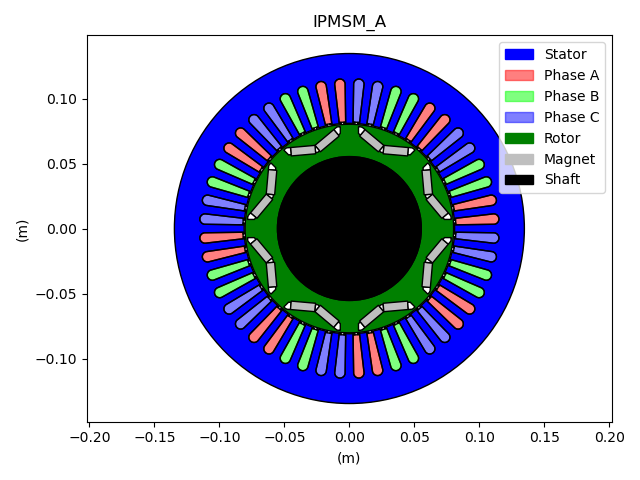

In [3]:
%matplotlib notebook

# Import the function 
from pyleecan.Functions.load import load 

# Load and plot the machine
IPMSM_A = load('pyleecan/Data/Machine/IPMSM_A.json')
im=IPMSM_A.plot()

### Defining Machine in scripting mode 
Pyleecan also enables to define the machine in scripting mode, using different classes. Each class is defined from a csv file in the folder _pyleecan/Generator/ClasseRef_ and the documentation of every class is available on the dedicated [webpage](https://www.pyleecan.org/pyleecan.Classes.html).
The following image shows the machine classes organization : 
![](https://www.pyleecan.org/_static/machine_classes_UML.png)

Every rotor and stator can be created with the Lamination class or one of its daughters.  
![](https://www.pyleecan.org/_static/lamination_classes_UML.png)


#### Stator definition
To define the stator, we initialize a [LamSlotWind](http://pyleecan.org/pyleecan.Classes.LamSlotWind.html) object with the different parameter.

In [4]:
from pyleecan.Classes.LamSlotWind import LamSlotWind
mm = 1e-3  # Millimeter


# Lamination setup
stator = LamSlotWind(
    Rint=80.95 * mm, # internal radius [m]
    Rext=134.62 * mm, # external radius [m]
    L1=83.82 * mm, # Lamination stack active length [m] without radial ventilation airducts 
                # but including insulation layers between lamination sheets
    Nrvd=0, # Number of radial air ventilation duct
    Kf1=0.95, # Lamination stacking / packing factor
    is_internal=False,
    is_stator=True, 
)

Then we add 48 slots using [SlotW11](http://pyleecan.org/pyleecan.Classes.SlotW11.html) which is one of the 25 Slot classes : 

In [5]:
from pyleecan.Classes.SlotW11 import SlotW11

# Slot setup
stator.slot = SlotW11(
    Zs=48, # Slot number
    H0=1.0 * mm,  # Slot isthmus height
    H1=0, # Height
    H2=33.3 * mm, # Slot height below wedge 
    W0=1.93 * mm,  # Slot isthmus width
    W1=5 * mm, # Slot top width
    W2=8 * mm, # Slot bottom width
    R1=0.004 # Slot bottom radius
)

As for the slot, we can define the winding and its conductor with [WindingDW1L](http://pyleecan.org/pyleecan.Classes.WindingDW1L.html) and [CondType11](http://pyleecan.org/pyleecan.Classes.CondType11.html):

In [6]:
from pyleecan.Classes.WindingDW1L import WindingDW1L
from pyleecan.Classes.CondType11 import CondType11
# Winding setup
stator.winding = WindingDW1L(
    qs=3,  # number of phases
    Lewout=0,  # staight length of conductor outside lamination before EW-bend
    p=4,  # number of pole pairs
    Ntcoil=9,  # number of turns per coil
    Npcpp=1,  # number of parallel circuits per phase
    Nslot_shift_wind=2,  # 0 not to change the stator winding connection matrix built by pyleecan number 
                         # of slots to shift the coils obtained with pyleecan winding algorithm 
                         # (a, b, c becomes b, c, a with Nslot_shift_wind1=1)
    is_reverse_wind=True # True to reverse the default winding algorithm along the airgap 
                         # (c, b, a instead of a, b, c along the trigonometric direction)
)

# Conductor setup
stator.winding.conductor = CondType11(
    Nwppc_tan=1, # stator winding number of preformed wires (strands) 
                 # in parallel per coil along tangential (horizontal) direction
    Nwppc_rad=1, # stator winding number of preformed wires (strands) 
                 # in parallel per coil along radial (vertical) direction
    Wwire=0.000912, #  single wire width without insulation [m]
    Hwire=2e-3, # single wire height without insulation [m]
    Wins_wire=1e-6, # winding strand insulation thickness [m]
    type_winding_shape=0, # type of winding shape for end winding length calculation
                          # 0 for hairpin windings
                          # 1 for normal windings
)

#### Rotor definition

For this example, we use the [LamHole](http://www.pyleecan.org/pyleecan.Classes.LamHole.html) class to define the rotor as a lamination with holes to contain magnet.

In the same way as for the stator, we start by defining the lamination:

In [7]:
from pyleecan.Classes.LamHole import LamHole

# Rotor setup
rotor = LamHole(
    Rint=55.32 * mm, # Internal radius
    Rext=80.2 * mm, # external radius
    is_internal=True, 
    is_stator=False,
    L1=stator.L1 # Lamination stack active length [m] 
                 # without radial ventilation airducts but including insulation layers between lamination sheets
)

After that, we can add holes with magnets to the rotor using the class [HoleM50](http://www.pyleecan.org/pyleecan.Classes.HoleM50.html): 

In [8]:
from pyleecan.Classes.HoleM50 import HoleM50
rotor.hole = list()
rotor.hole.append(
    HoleM50(
        Zh=8, # Number of Hole around the circumference
        W0=42.0 * mm,  # Slot opening
        W1=0, # Tooth width (at V bottom)
        W2=0, # Distance Magnet to bottom of the V
        W3=14.0 * mm, # Tooth width (at V top)
        W4=18.9 * mm, # Magnet Width
        H0=10.96 * mm, # Slot Depth
        H1=1.5 * mm, # Distance from the lamination Bore
        H2=1 * mm, # Additional depth for the magnet
        H3=6.5 * mm, # Magnet Height
        H4=0, # Slot top height
    )
)

#### Create a shaft and a frame

The classes [Shaft](http://www.pyleecan.org/pyleecan.Classes.Shaft.html) and [Frame](http://www.pyleecan.org/pyleecan.Classes.Frame.html) enable to add a shaft and a frame to the machine for this example there is no shaft:

In [9]:
from pyleecan.Classes.Shaft import Shaft
from pyleecan.Classes.Frame import Frame

# Set shaft
shaft = Shaft(Drsh=rotor.Rint * 2, # Diamater of the rotor shaft [m]
                                   # used to estimate bearing diameter for friction losses
              Lshaft=1.2 # length of the rotor shaft [m] 
             )


#### Set materials and magnets

Every Pyleecan object can be saved in JSON using the method _save_ and can be loaded with the _load_ function.
In this example, the materials *M400_50A* and *Copper1* are loaded while the material *Magnet_prius* is created with the classes [Material](http://www.pyleecan.org/pyleecan.Classes.Material.html) and [MatMagnetics](http://www.pyleecan.org/pyleecan.Classes.MatMagnetics.html).

In [11]:
from pyleecan.Classes.Material import Material
from pyleecan.Classes.MatMagnetics import MatMagnetics


# Loading Materials 
M400_50A = load('pyleecan/Data/Material/M400-50A.json')
Copper1 = load('pyleecan/Data/Material/Copper1.json')

# Defining magnets
Magnet_prius = Material(name="Magnet_prius")

# Definition of the magnetic properties of the material
Magnet_prius.mag = MatMagnetics(
    mur_lin = 1.05, # Relative magnetic permeability
    Hc = 902181.163126629, # Coercitivity field [A/m]
    alpha_Br = -0.001, # temperature coefficient for remanent flux density /°C compared to 20°C
    Brm20 = 1.24, # magnet remanence induction at 20°C [T]
    Wlam = 0, # lamination sheet width without insulation [m] (0 == not laminated)
)

# Definition of the electric properties of the material 
Magnet_prius.elec.rho = 1.6e-06 # Resistivity at 20°C

# Definition of the structural properties of the material
Magnet_prius.struct.rho = 7500.0 # mass per unit volume [kg/m3]


# Set Materials
stator.mat_type = M400_50A
rotor.mat_type = M400_50A
stator.winding.conductor.cond_mat = Copper1

# Set magnets in the rotor hole
rotor.hole[0].magnet_0.mat_type = Magnet_prius
rotor.hole[0].magnet_1.mat_type = Magnet_prius
rotor.hole[0].magnet_0.type_magnetization = 1
rotor.hole[0].magnet_1.type_magnetization = 1

#### Create, save and plot the machine
Finally, the Machine object can be created with [MachineIPMSM](http://www.pyleecan.org/pyleecan.Classes.MachineIPMSM.html) and saved using the _save_ method.

<IPython.core.display.Javascript object>


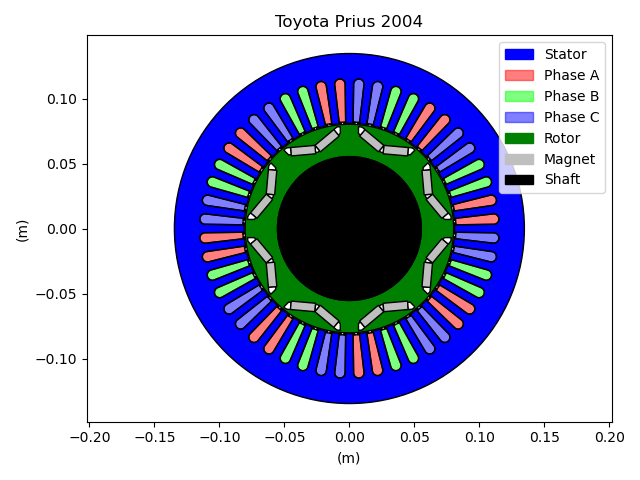

In [14]:
from pyleecan.Classes.MachineIPMSM import MachineIPMSM

%matplotlib notebook
IPMSM_Prius_2004 = MachineIPMSM(
    name="Toyota Prius 2004", 
    stator=stator, 
    rotor=rotor, 
    shaft=shaft, 
    frame=None
)
IPMSM_Prius_2004.save('Tutorials/IPMSM_Toyota_Prius_2004.json')

im=IPMSM_Prius_2004.plot()

Note that Pyleecan also handles ventilation duct thanks to the classes :  
- [VentilationCirc](http://www.pyleecan.org/pyleecan.Classes.VentilationCirc.html)  
- [VentilationPolar](http://www.pyleecan.org/pyleecan.Classes.VentilationPolar.html)  
- [VentilationTrap](http://www.pyleecan.org/pyleecan.Classes.VentilationTrap.html)  

[1] Z. Yang, M. Krishnamurthy and I. P. Brown, "Electromagnetic and vibrational characteristic of IPM over full torque-speed range", *2013 International Electric Machines & Drives Conference*, Chicago, IL, 2013, pp. 295-302.